# Chap4 特征处理

本章主要学习：

 - 特征抽取：将现实世界的数据构建为sklearn中可用的特征数据

 - 特征选择：从可用的特征数据中，选择适当的特征集。

 - 模型选择：选择合适的算法和参数


 ## 特征抽取
 
 根据机器学习的需要将潜在的特征转换为学习方法所需要的格式被称为特征抽取或特征工程。通常可以分为两步：

 - 获取特征：对源数据进行处理并提取学习样本，通常用特征/值对的形式表示，值可以是整数、浮点、字符串、分类代码等。提取特征的方法则严重依赖于源数据。

 - 特征转换：多数sklearn算法需要的样本集是list形式的，特征值为浮点类型。

 Pandas可以用于对数据的预处理，它提供了类似R语言的功能。

 下面将使用Pandas将tatanic.csv 数据转换为pandas和DataFrame格式（DataFrame是二维标签数据，列可以包含不同的数据类型，每行表示一个样本）

In [71]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

titanic = pd.read_csv('titanic.csv')
#print(titanic)
print(titanic.head()[['pclass','survived','age','embarked','boat','sex']])

Populating the interactive namespace from numpy and matplotlib
  pclass  survived      age     embarked   boat     sex
0    1st         1  29.0000  Southampton      2  female
1    1st         0   2.0000  Southampton    NaN  female
2    1st         0  30.0000  Southampton  (135)    male
3    1st         0  25.0000  Southampton    NaN  female
4    1st         1   0.9167  Southampton     11    male


/Users/zhujie/.pyenv/versions/2.7.14/envs/machinelearn/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


主要问题是sklearn的方法需要特征为实数值。在第二章中我们使用了LabelEncoder和OneHotEncoder预处理方法手工将分类特征转换为了1-of-K值（每个可能的值都生成为一个特征，原特征值匹配时值为1，其它特征值为0）。这次，我们使用sklarn中类似的方法DictVectorizer，它能自动的从不同的原始特征值构造这些特征。

In [72]:
from sklearn import feature_extraction
def one_hot_dataframe(data,cols,replace=False):
    vec = feature_extraction.DictVectorizer()
    mkdict = lambda row:dict((col,row[col]) for col in cols)
    vecData = pd.DataFrame(vec.fit_transform(
        data[cols].apply(mkdict,axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    if replace:
        data = data.drop(cols,axis=1)
        data = data.join(vecData)
        return (data,vecData)


one_hot_dataframe方法接收pandas DataFrame 数据结构和列头信息，将每个列转换换为1-of-K特征。如果replace参数为True，它将使用新的特征集替换掉原来的列。下面使用它来处理pclass，embarked和sex特征。

In [73]:
titanic,titanic_n = one_hot_dataframe(titanic,['pclass','embarked','sex'],replace=True)
titanic.describe()

         row.names     survived         age  embarked  embarked=Cherbourg  \
count  1313.000000  1313.000000  633.000000     821.0         1313.000000   
mean    657.000000     0.341965   31.194181       0.0            0.154608   
std     379.174762     0.474549   14.747525       0.0            0.361668   
min       1.000000     0.000000    0.166700       0.0            0.000000   
25%     329.000000     0.000000   21.000000       0.0            0.000000   
50%     657.000000     0.000000   30.000000       0.0            0.000000   
75%     985.000000     1.000000   41.000000       0.0            0.000000   
max    1313.000000     1.000000   71.000000       0.0            1.000000   

       embarked=Queenstown  embarked=Southampton   pclass=1st   pclass=2nd  \
count          1313.000000           1313.000000  1313.000000  1313.000000   
mean              0.034273              0.436405     0.245240     0.213252   
std               0.181998              0.496128     0.430393     0.4097

pclass属性被转换为了3个特征：pclass=1st，pclass=2nd，pclass=3rd。embarked列并没有消失，这是因为原始的embarked属性中包含了NaN值，即缺失值，这种情况下embarked属性有值的样本的新特征值会被设置为0，NaN值仍然不变，表示这个特征是缺失的。接下来处理其分类值：

In [74]:
titanic,titanic_n = one_hot_dataframe(titanic,['home.dest','room','ticket','boat'],replace=True)

我们也可惟处理缺失值，由于DecisionTreeClassifier分类器不允许有缺失值。Pandas的fillna方法可以处理缺失值。这里我们使用年龄的平均值填充缺失的年龄特征，用0填充其它缺失的特征。

In [75]:
mean = titanic['age'].mean()
titanic['age'].fillna(mean,inplace=True)
titanic.fillna(0,inplace=True)

现在除了name属性其它属性都已经进行了处理。接下来可以划分测试和训练集。

In [76]:
from sklearn.cross_validation import train_test_split
titanic_target = titanic['survived']
titanic_data = titanic.drop(['name','row.names','survived'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(titanic_data,titanic_target,test_size=0.25,random_state=33)


这里丢弃了name属性，因为它与生存状态无关（每个样本的值都不同）。我们将survived特征作为了目标值，因此可以从训练向量中排除。


In [77]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt = dt.fit(X_train,y_train)
from sklearn import metrics
y_pred = dt.predict(X_test)
print("精度:{0:.3f}".format(metrics.accuracy_score(y_test,y_pred)))

精度:0.833


## 特征选择
到目前为止，当我们训练决策树时，我们使用了数据集中所有可用的特征。这看起来似乎比较合理，因为我们想要用尽量多的特征来构建模型。实际上，由于两个主要的原因，我们应该限制使用的特征数量：

 - 首先，对于某些方法，特别是那些会逐步重建样本数量的方法（比如决策树），有可能那些不相关的特征的偶然出现会导致不能正确的模拟问题。某些特征可能会导致模型的泛化能力不佳。另外一些特征可能高度相关，它只是增加了一些冗余信息。

 - 第二个原因则比较现实。大量特征可能会显著的增加计算时间，而对分类性能提升没有帮助。特别是在进行大数据处理时，这种情况下样本和特征可能会数千倍的增加。另外，与维度灾难相关，使用包含大量特征和样本的数据集训练出一个泛化的模型是非常困难的。
 
因此，使用数量较少的特征可能会获得更好的效果。因此我们需要一个找出最佳特征的算法。这项任务被称为特征选择，它是一个决定性的步骤。如果我们的特征太弱，则算法将返回不良的结果，不论选择的算法有多强。

例如在Titanic示例中，如果我们将11个特征进行1-of-K编码处理，将会增涨到581个特征。这还不构成重要的计算问题，但是考虑一下，如果像前面的示例那样，将数据集中的每个文档表示为每个词出现的次数会发生什么情况？另一个问题是决策树会过拟合。如果分支上只有少量的样本，模型的预测能力将会下降。解决这个问题的一个方法是调整模型参数（比如最大的树深度，叶节点的最小样本数量）。但是在这里，我们将采取不同的方法：我们尝试将特征限制在最相关的特征上。

相关性如何表示呢？这是个重要的问题。如果特征总是与目标分类一致（即它是一个强大的标识指标），足以表征数据。另一方面，如果特征总是具有相同的值，那么它的预测能力就会很低。

特征选择的一般机制是找到某种评估函数，当给定一个潜在特征时，它返回特征有用程度的评分，然后保留评估最高 的特征。这些方法可能具有不检测特征之间的相关性的缺点。其它方法可能会更加暴力：尝试原始特征列表的所有可能的子集，在每个组合上训练算法，保留结果最好的组合。

我们可以统计对两个随机变量（给定特征和目标值）的无关性来对评估函数进行评估；也就是说，它们之间是没有相关性的。

Sklearn在feature_selection模块中提供了多个方法。我们将使用SelectPercentile方法，它根据用户指定的百分比选择得分最高的特征。最流行的统计校验是卡方统计。我们用Titanic为例；选择最重要的20% 特征。

In [78]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile=20)
X_train_fs = fs.fit_transform(X_train,y_train)
# 现在这个变量保存了统计意义上的最重要的特征。我们以它来训练决策树
dt.fit(X_train_fs,y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
print("精度：{0:.3f}".format(metrics.accuracy_score(y_test,y_pred_fs)))

精度：0.848


精度有所提升。

是否能找到最理想的数量的特征呢？理想的情况下我们希望在训练集上得到最佳的性能，这也是可能通过暴力算法尝试所有不同数量的特征然后在训练集上使用交叉验证进行评估。

[13]
理想的特征数量：
66


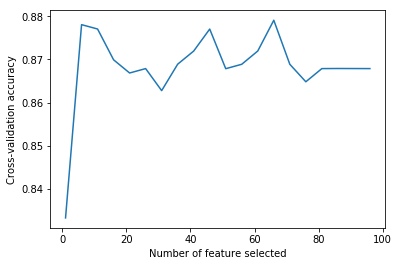

In [79]:
from sklearn import cross_validation

percentiles = range(1,100,5)
results = []
for i in range(1,100,5):
    fs = feature_selection.SelectPercentile(
        feature_selection.chi2,percentile=i
    )
    X_train_fs = fs.fit_transform(X_train,y_train)
    scores = cross_validation.cross_val_score(dt,X_train_fs,y_train,cv=5)
    results = np.append(results,scores.mean())

#print results    
optimal_percentil = np.where(results == results.max())[0]
print optimal_percentil
print("理想的特征数量：")
print(percentiles[optimal_percentil[0]])

import pylab as pl

pl.figure()
pl.xlabel("Number of feature selected")
pl.ylabel("Cross-validation accuracy")
pl.plot(percentiles,results)
pl.show()

可以看到在开始阶段添加特征时精度快速提升，到超过6之后出现波动。我们可以观察它是否在测试集上能提升性能。

In [80]:
fs = feature_selection.SelectPercentile(
    feature_selection.chi2,
    percentile = percentiles[optimal_percentil[0]])
X_train_fs = fs.fit_transform(X_train,y_train)
dt.fit(X_train_fs,y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
print("精度：{0:.3f}".format(metrics.accuracy_score(y_test,y_pred_fs)))

精度：0.845


性能提升明显。

前面在构建分类器时，使用了默认参数，除了criterion(分裂标准) 参数使用的是entropy。我们可以使用不同的参数来进行提升？这项任务被称为模型选择。这里我们先使用gini来代替entropy。

In [81]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
scores = cross_validation.cross_val_score(dt,X_train_fs,y_train,cv=5)
print("Entropy分裂：{0:.3f}".format(scores.mean()))

dt = tree.DecisionTreeClassifier(criterion='gini')
scores = cross_validation.cross_val_score(dt,X_train_fs,y_train,cv=5)
print("Gini分裂：{0:.3f}".format(scores.mean()))

dt.fit(X_train_fs,y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
print("精度{0:.3f}".format(metrics.accuracy_score(y_test,y_pred_fs)))

Entropy分裂：0.874
Gini分裂：0.879
精度0.845


修改模型可以在测试集上得到更好的性能，但我们不能在测试集上评估，因为测试集数据都不是模型“未见过”的数据。

## 模型选择
前一节我们在数据预处理环节，选择最重要的特征。选择特征是决定性的环节。现在我们聚焦于另一个重要的步骤：算法参数，即超参数（区别于机器学习算法内部的参数）。许多机器学习算法都有超参数，它用于指引下层的方法并对结果产生重大的影响。本节我们将回顾一些方法用于获取最佳的参数配置，这个过程被称为模型选择。

在第二章的文本分类问题中。我们介绍使用TF-IDF向量和多项式贝叶斯算法对新闻进行分类。MultinomialNB算法有一个重要的参数，alpha参数。最初我们使用了它的默认值（alpha=1.0）得到的精度是0.89。当将它设置为0.01时得到的精度提升至了0.92。配置这个参数对这个算未予的性能影响非常大。我们怎样才能知道0.01这个参数值更好呢？我们可以尝试其它可能值，获得到更好的效果。

这里我们使用3000个样本。

In [82]:
#%pylab inline
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups(subset='all')
n_samples = 3000
X_train = news.data[:n_samples]
y_train = news.target[:n_samples]

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

然后导入停用词并创建组合TF-IDF向量和算法和管道。

In [83]:
def get_stop_words():
    result = set()
    for line in open('stopwords_en.txt','r').readlines():
        result.add(line.strip())
    return result
    
stop_words = get_stop_words()
clf = Pipeline([('vect',TfidfVectorizer(
    stop_words = stop_words,
    token_pattern = ur"\b[a-z0-9_\-\.]+[a-z0-9_\-\.]+\b")),
               ('nb',MultinomialNB(alpha=0.01))])

        

使用三折交叉验证法：

In [84]:
from sklearn.cross_validation import cross_val_score,KFold

from scipy.stats import sem

def evaluate_cross_validation(clf,X,y,K):
    # 创建k折交叉验证
    cv = KFold(len(y),K,shuffle=True,random_state=0)
    # 默认的score返回评估器的score（精度）方法返回的值
    scores = cross_val_score(clf,X,y,cv=cv)
    print(scores)
    print("均值：{0:.3f}(+/-{1:.3f})".format(
        np.mean(scores),sem(scores)))

evaluate_cross_validation(clf,X_train,y_train,3)

[ 0.812  0.806  0.831]
均值：0.816(+/-0.008)


看起来我们应该使用一些不同的参数来训练算法，并保留获取最佳结果的参数。下面的函数将使用一组值来训练算法，每次使用k折交叉验证法计算精度。之后它绘制出训练集和测试集上的得分。

In [101]:
def calc_params(X,y,clf,param_values,param_name,K):
    # 将训练和测试分值初始化为0
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))

    # 遍历所有参数值
    for i, param_value in enumerate(param_values):
        print('{} = {} '.format(param_name,param_value))
        # 设置分类器参数
        clf.set_params(**{param_name:param_value})
        # 初始化每折验证的K值
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        # 创建K折交叉验证
        cv = KFold(n_samples,K,shuffle=True,random_state=0)
        # 遍历所有K 折
        for j, (train,test) in enumerate(cv):
            clf.fit([X[k] for k in train],y[train])
            k_train_scores[j] = clf.score([X[k] for k in train],y[train])
            k_test_scores[j] = clf.score([X[k] for k in test],y[test])

        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)

    # 绘制训练集测试集分值
    plt.semilogx(param_values,train_scores,alpha=0.4,lw=2,c='b')
    plt.semilogx(param_values,test_scores,alpha=0.4,lw=2,c='g')
        
    plt.xlabel("Alpha values")
    plt.ylabel("Mean Cross-validation accuracy")
    return train_scores,test_scores
         

这个函数接收6个参数：特征数组，目标数组，分类器对象，参数列表，参数名称，交叉验证次数k的值。

接下来调用函数，我们使用numpy的logspace函数在对数空间上生成alpha值列表。

In [99]:
alphas = np.logspace(-7,0,8)
print(alphas)

[  1.00000000e-07   1.00000000e-06   1.00000000e-05   1.00000000e-04
   1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00]


我们将这些值作为pipeline中朴素贝叶斯分类器的alpha参数，它的参数名称为nb__alpha。我们使用3折交叉验证。

nb__alpha = 1e-07 
nb__alpha = 1e-06 
nb__alpha = 1e-05 
nb__alpha = 0.0001 
nb__alpha = 0.001 
nb__alpha = 0.01 
nb__alpha = 0.1 
nb__alpha = 1.0 


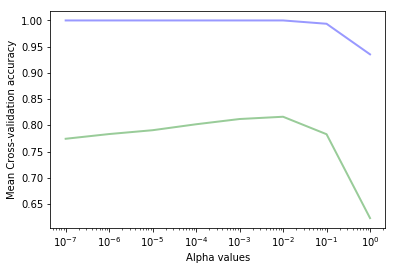

In [102]:

train_scores,test_scores = calc_params(X_train,y_train,clf,alphas,'nb__alpha',3)

可以看到与我们预计的情况一样，训练集上的精度总是大于测试集上的精度。我们可以看到上图中最高的测试集精度的alpha值在 $10^{-2}$ 和 $10^{-1}$ 之间。在这个区间分类器显示出过拟合（训练集精度高但测试集精度低）。在这个区间之上，分类器则欠拟合（训练集精度过低）。

值得注意的是可以在 $10^(-2)$ 和 $10^(-1)之间找到最佳的alpha值$。


In [103]:
print("train scores：{}".format(train_scores))
print("test scores: {}".format(test_scores))

train scores：[ 1.          1.          1.          1.          1.          1.
  0.99366667  0.93533333]
test scores: [ 0.77433333  0.78333333  0.79066667  0.802       0.812       0.81633333
  0.783       0.623     ]


最佳的alpha值是0.1（得到的精度是0.812）。

上面我们创建了一个非常有用的函数绘制和评估分类吕的最佳参数值。接下来让我们调整另一个分类器，使用SVM代替NB。

svc__gamma = 0.01 
svc__gamma = 0.1 
svc__gamma = 1.0 
svc__gamma = 10.0 


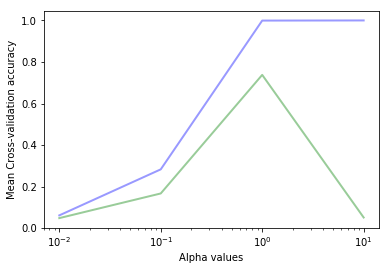

In [110]:
from sklearn.svm import SVC
clf = Pipeline([
    ('vect',TfidfVectorizer(
        stop_words = stop_words,
        token_pattern = ur"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")),
    ('svc',SVC())
])
`
# 在使用SVC 分类器前我们将使用 calc_params 函数调整它的 gamma 参数

gammas = np.logspace(-2,1,4)
train_scores,test_scores = calc_params(X_train,y_train,clf,gammas,'svc__gamma',3)


最佳的gamma值是1，这个参数得到的训练集精度是0.999测试集上的精度是0.760。

如果仔细看SVC类的构建器参数，我们可以找到其它参数，除了gamma外，它们也可以影响分类效果。如果我们只调整gamma值，我们隐式的得到最优的C参数值为1.0（默认值我们没有显式的指定）。也许我们使用另一对C和gamma的组合能得到更好的结果。这增加了新的复杂度，我们应该尝试所有可能的组合并保留更好的值。

## 网格搜索(Grid Search)
为处理这个问题，`sklarn.grid_search` 模块提供了GridSearchCV类。前面我们的 `calc_params` 函数也是一个一维的网格搜索。使用GridSearchCV，我们可以指定一个包含任意数量的参数和参数值的网格并进行遍历。它将使用所有可能的参数组合训练分类器，并使用交叉难器计算每种组合。

我们使用C和gamma参数进行调优。


In [114]:
from sklearn.grid_search import GridSearchCV

parameters = {'svc__gamma':np.logspace(-2,1,4),
             'svc__C':np.logspace(-1,1,3)}
clf = Pipeline([
    ('vect',TfidfVectorizer(stop_words = stop_words,
                            token_pattern = ur"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")),
    ('svc',SVC())
])

gs = GridSearchCV(clf,parameters,verbose=2,refit=False,cv=3)

%time _ = gs.fit(X_train,y_train)
gs.best_params_,gs.best_score_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] svc__gamma=0.01, svc__C=0.1 .....................................
[CV] ............................ svc__gamma=0.01, svc__C=0.1 -  11.2s
[CV] svc__gamma=0.01, svc__C=0.1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ............................ svc__gamma=0.01, svc__C=0.1 -  10.8s
[CV] svc__gamma=0.01, svc__C=0.1 .....................................
[CV] ............................ svc__gamma=0.01, svc__C=0.1 -  10.9s
[CV] svc__gamma=0.1, svc__C=0.1 ......................................
[CV] ............................. svc__gamma=0.1, svc__C=0.1 -  11.0s
[CV] svc__gamma=0.1, svc__C=0.1 ......................................
[CV] ............................. svc__gamma=0.1, svc__C=0.1 -  11.6s
[CV] svc__gamma=0.1, svc__C=0.1 ......................................
[CV] ............................. svc__gamma=0.1, svc__C=0.1 -  10.9s
[CV] svc__gamma=1.0, svc__C=0.1 ......................................
[CV] ............................. svc__gamma=1.0, svc__C=0.1 -  11.4s
[CV] svc__gamma=1.0, svc__C=0.1 ......................................
[CV] ............................. svc__gamma=1.0, svc__C=0.1 -  11.5s
[CV] svc__gamma=1.0, svc__C=0.1 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.7min finished


({'svc__C': 10.0, 'svc__gamma': 0.10000000000000001}, 0.819)

使用网格搜索，我们找到了最佳的C和gamma参数组合，10.0和0.10，其3折交叉难的精度为0.811，比之前只优化gamma参数时C默认取1.0时得到的更好一些（当时的精度为0.76）。

现在，我们可以继续尝试调整其它参数，不仅限于SVC的参数，也可以调整TfidfVectorizer的参数，因为它也是评估器的一部分。这又将增加更多的复杂性。前面的网络搜索已经需要花超过5分钟的时间来运行了。这种方法是需要消耗大量的资源和时间的；这也是我们只使用整个训练集的一个子集的原因。

## 并行网格搜索

网格搜索的计算量是按要调优的参数的数量呈几何级数增长的。我们可以通过让每种参数组合以并行的方式运行就可以提高响应的速度。前面的例子中，我们有4个gamma值和3个C值共12种参数组合。另外，我们还需要训练每种组合三次（3折交叉验证）。我们可以将这36个任务并行，因为每个任务都是独立的。

现代的计算机都有多个CPU核心可以并行运行任务。在IPython中也有一个非常有用的工具IPython parallel，它允许我们以并行的方式运行多个任务，每个任务使用机器的一个CPU核心。

首先，我们需要定义一下新的函数将K折交叉验证的数据放在不同的文件中。这些文件将被运行对应折次的进程所加载。我们使用joblib来实现。

In [120]:
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

def persist_cv_splits(X,y,K=3,name='data',
                      suffix='_cv_%03d.pkl'):
    """Dump K folds to filesystem."""

    cv_split_filenames = []

    # 创建K折交叉验证
    cv = KFold(n_samples,K,shuffle=True,random_state=0)

    # 遍历 K 折
    for i,(train,test) in enumerate(cv):
        cv_fold = ([X[k] for k in train],y[train],
                   [X[k] for k in test],y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold,cv_split_filename)
        cv_split_filenames.append(cv_split_filename)

    return cv_split_filenames

cv_filenames = persist_cv_splits(news.data,news.target,name='news')


下面的函数加载某个指定的fold并将它送给设置了特定参数的分类器，返回测试结果。这个函数将被每个并行任务所调用。

In [177]:
def compute_evaluation(cv_split_filename,clf,params):
    # 应该在工作进程的空间导入模块
    from sklearn.externals import joblib

    # 从文件系统加载 fold 的训练和测试分块
    X_train,y_train,X_test,y_test = joblib.load(
        cv_split_filename,mmap_mode='c')

    clf.set_params(**params)
    clf.fit(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    return test_score



最终由下面的函数在并行任务中执行网格搜索。对于每个参数组合（由IterGrid返回），它遍历K folds并创建任务进行计算。它返回参数组合和任务列表。

In [178]:
# from sklearn.grid_search import IterGrid
# http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.ParameterGrid.html#sklearn.grid_search.ParameterGrid
from sklearn.model_selection import ParameterGrid

def parallel_grid_search(lb_view,clf,cv_split_filenames,param_grid):
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))

    # 遍历所有参数组合
    for i,params in enumerate(all_parameters):
        task_for_params = []
        for j,cv_split_filename in enumerate(cv_split_filenames):
            t = lb_view.apply(
                compute_evaluation,cv_split_filename,clf,
                params)
            task_for_params.append(t)
    
    all_tasks.append(task_for_params)
    return all_parameters,all_tasks    


现在我们使用IPython Parallel获取客户端和负责均衡view(lb_view)。我们必须先使用IPython Notebook的Cluster 页签，创建一个本部N引擎的集群（每个对应于机器上的一个CPU核）。

In [179]:
from sklearn.svm import SVC
#from IPython.parallel import Client
# 上面的功能已经变化
# 参见https://github.com/ipython/ipyparallel
# 需要安装ipyparallel并运行
# ipcluster nbextension enable 启动ipython notebook的cluster 页签
# ipcluster start 启动并行支持
from ipyparallel import Client

client = Client()
lb_view = client.load_balanced_view()

all_parameters,all_tasks = parallel_grid_search(
    lb_view,clf,cv_filenames,parameters)



IPython parallel将以并行方式运行任务。我们可以它监控整个任务组的进行进度。


In [182]:
def print_progress(tasks):
    progress = np.mean([task.ready() for task_group in tasks for task in task_group])
    print("任务完成情况:{}".format(100*progress))
    
print_progress(all_tasks)

任务完成情况:100.0


我们可以定义函数计算已完成任务的平均分值。

In [183]:
def find_bests(all_parameters,all_tasks,n_top=5):
    """计算已完成任务的平均分值"""

    mean_scores = []

    for param,task_group in zip(all_parameters,all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores)==0:
            continue
        mean_scores.append((np.mean(scores),param))

    return sorted(mean_scores,reverse=True)[:n_top]

print(find_bests(all_parameters,all_tasks))



[(0.053666666666666668, {'svc__gamma': 0.01, 'svc__C': 0.10000000000000001})]


## 小结
本章回顾了机器学习中两个重要的提高效果的方法：特征选择和模型选择。首先，我们使用不同的技术进行数据预处理，特征抽取，并选择最有价值的特征。然后我们使用技术自动计算最有价值的超参数，并使用并行计算提升性能。

读者需要了解本书只包含部分机器学习方法。还有大量监督和非监督学习方法。比如：

 - 半监督学习算法，介于监督学习和非监督学习之间。它将少量标记过的数据与未标记的数据进混合在一起。通常未标记的数据可以由下层标记过的数据揭示出数据的分布。

 - Active learning是半监督学习的一个特殊类型。它在难以提供标记数据时非常有效。在active learning中算法积极的请求人类专家回答某些未分类样本的标签，然后学习这些标签样本的特征。

 - 强化学习通过反馈信息提高学习效果，它的代理从反馈中进行学习。代理尝试最大化累积奖励来执行任务。这些方法在机器人和视频游戏方面非常成功。

 - 顺序分类（常用于自然语言处理（NLP））将一系列标签分配给一系列项目; 例如，一个句子中词语的词性。

除了这些，还有很多监督学习方法与我们提出的方法截然不同。 例如神经网络，最大熵模型，基于记忆的模型和基于规则的模型。 机器学习是一个非常活跃的研究领域，不断增长的文献， 有很多书籍和课程可供读者深入理论和细节。

Sklearn 已经实现这些算法中的许多种，缺少部分算法，但期望它的积极和热心的贡献者能建立它们。 我们鼓励读者成为社区的一员！
